In [1]:
!pip install modAL

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import csv
import time
import pickle
import pandas as pd
import numpy as np
from functools import partial
import seaborn as sn


import tensorflow as tf
from tensorflow import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator

from modAL.models import ActiveLearner
from modAL.uncertainty import *
from modAL.batch import uncertainty_batch_sampling


import matplotlib.pyplot as plt
%matplotlib inline

import warnings

In [3]:
filePathName = './RandomForest.pkl'
loaded_model = pickle.load(open(filePathName, 'rb'))

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [4]:
useStats = 1
useAttributeName = 1
useSample1 = 0
useSample2 = 0
## Using descriptive stats and attribute name

In [5]:
dict_label = {
    'numeric': 0,
    'categorical': 1,
    'datetime': 2,
    'sentence': 3,
    'url': 4,
    'embedded-number': 5,
    'list': 6,
    'not-generalizable': 7,
    'context-specific': 8
}

dict_label_list = [k for k,v in sorted(dict_label.items(), key = lambda x: x[1])]
print(dict_label_list)

['numeric', 'categorical', 'datetime', 'sentence', 'url', 'embedded-number', 'list', 'not-generalizable', 'context-specific']


In [6]:
def ProcessStats(data,y):

    data1 = data[['total_vals', 'num_nans', '%_nans', 'num_of_dist_val', '%_dist_val', 'mean', 'std_dev', 'min_val', 'max_val','has_delimiters', 'has_url', 'has_email', 'has_date', 'mean_word_count',
       'std_dev_word_count', 'mean_stopword_total', 'stdev_stopword_total',
       'mean_char_count', 'stdev_char_count', 'mean_whitespace_count',
       'stdev_whitespace_count', 'mean_delim_count', 'stdev_delim_count',
       'is_list', 'is_long_sentence']]
    data1 = data1.reset_index(drop=True)
    data1 = data1.fillna(0)

    y.y_act = y.y_act.astype(float)
    
    return data1

vectorizerName = CountVectorizer(ngram_range=(2, 2), analyzer='char')
vectorizerSample = CountVectorizer(ngram_range=(2, 2), analyzer='char')

def FeatureExtraction(data,data1,flag):

    arr = data['Attribute_name'].values
    arr = [str(x) for x in arr]
    
    arr1 = data['sample_1'].values
    arr1 = [str(x) for x in arr1]
    arr2 = data['sample_2'].values
    arr2 = [str(x) for x in arr2]
    arr3 = data['sample_3'].values
    arr3 = [str(x) for x in arr3]    
    #print(len(arr1),len(arr2))
    if flag:
        X = vectorizerName.fit_transform(arr)
        X1 = vectorizerSample.fit_transform(arr1)
        X2 = vectorizerSample.transform(arr2)   
    else:
        X = vectorizerName.transform(arr)
        X1 = vectorizerSample.transform(arr1)
        X2 = vectorizerSample.transform(arr2)        
        
#     print(f"> Length of vectorized feature_names: {len(vectorizer.get_feature_names())}")

    attr_df = pd.DataFrame(X.toarray())
    sample1_df = pd.DataFrame(X1.toarray())
    sample2_df = pd.DataFrame(X2.toarray())
    #print(len(data1),len(attr_df),len(sample1_df),len(sample2_df))

    if useSample1: data2 = sample1_df
    if useSample2: data2 = sample2_df    
    
    data2 = pd.concat([data1, attr_df], axis=1, sort=False)
    #print(len(data2))
    return data2



In [7]:
def get_data(sim_size = 0.8):
    """
    sim_size is the % of training data that goes into simulation set.
    """
    xtrain = pd.read_csv('./data_train.csv')
    xtest = pd.read_csv('./data_test.csv')

    y_train = xtrain.loc[:,['y_act']]
    y_test = xtest.loc[:,['y_act']]
    y_train['y_act'] = [dict_label[i] for i in y_train['y_act']]
    y_test['y_act'] = [dict_label[i] for i in y_test['y_act']]
    
    xtrain1 = ProcessStats(xtrain,y_train)
    xtest1 = ProcessStats(xtest,y_test)


    X_train = FeatureExtraction(xtrain,xtrain1,1)
    X_test = FeatureExtraction(xtest,xtest1,0)


    X_train_new = X_train.reset_index(drop=True)
    y_train_new = y_train.reset_index(drop=True)
    X_train_new = X_train_new.values
    y_train_new = y_train_new.values
    
    # setting up data
    X_train_AL, X_simulation_AL, y_train_AL, y_simulation_AL = train_test_split(X_train_new, y_train, test_size=sim_size, stratify = y_train)
    # Start AL loops simulated with a part of the test data
    X_simulation_df = pd.DataFrame(X_simulation_AL)
    y_simulation_df = pd.DataFrame(y_simulation_AL)
    # making copies of existing X_test and y_test data
    X_test_AL = pd.DataFrame(X_test)
    y_test_AL = pd.DataFrame(y_test)
    
    assert len(X_train_AL) == len(y_train_AL)
    assert len(X_simulation_df) == len(y_simulation_df)
    assert len(X_test_AL) == len(y_test_AL)
    return X_train_AL, y_train_AL, X_simulation_df, y_simulation_df, X_test_AL, y_test_AL

X_train, y_train, X_sim, y_sim, X_test, y_test = get_data()
print(f"Training set size: {len(X_train)}, Simulation set size: {len(X_sim)}, Test set size: {len(X_test)}")


Training set size: 1587, Simulation set size: 6349, Test set size: 1985


In [8]:
print(X_train.shape, y_train.shape)
print(X_sim.shape, y_sim.shape)
print(X_test.shape, y_test.shape)

(1587, 1478) (1587, 1)
(6349, 1478) (6349, 1)
(1985, 1478) (1985, 1)


In [9]:
def grid_parameter_search(X_train, y_train, X_test, y_test, n_estimators_grid, max_depth_grid, query_size):
    best_model_score = 0
    
    preset_batch = partial(uncertainty_sampling, n_instances=query_size)
    
    for ne in n_estimators_grid:
        for md in max_depth_grid:
            learner = ActiveLearner(
                  estimator=RandomForestClassifier(n_estimators=ne, max_depth=md, random_state=100),
                  X_training=X_train, y_training=y_train,
                  query_strategy=preset_batch
                )
            score = learner.score(X_test, y_test)
            print(f"[n_estimator: {ne}, max_depth: {md}, accuracy: {score}]")
            if best_model_score < score:
                best_ne = ne
                best_md = md
                best_model_score = score
                bestPerformingModel = learner
    print(f"best model found at ne:{best_ne}, md:{best_md}, at score:{best_model_score}")
    return learner, best_ne, best_md, best_model_score


#learner, best_ne, best_md, best_model_score = grid_parameter_search(X_train, y_train, X_sim, y_sim, [i*100 for i in range(1,11)],[i*100 for i in range(11)], 100)
#print(f"[BEST OBTAINED RF ESTIMATOR] === [n_estimator: {best_ne}, max_depth: {best_md}, accuracy: {best_model_score}]")

In [10]:
def save_his(data, full_path):
    assert data != None and len(data.items()) > 0, "data should not be empty"
    
    with open(full_path, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(list(data.keys()))
        writer.writerows(zip(*data.values()))
    

test_data_1 = [i for i in range(100)]
test_data_2 = [i*2 for i in range(100)]
test_data_3 = [i*3 for i in range(100)]
test_data_4 = [i*4 for i in range(100)]
data = {"num_queries": test_data_1, "time": test_data_2, "total_time":test_data_3, "test_accuracy":test_data_4}

save_his(data, "./his/test.csv")

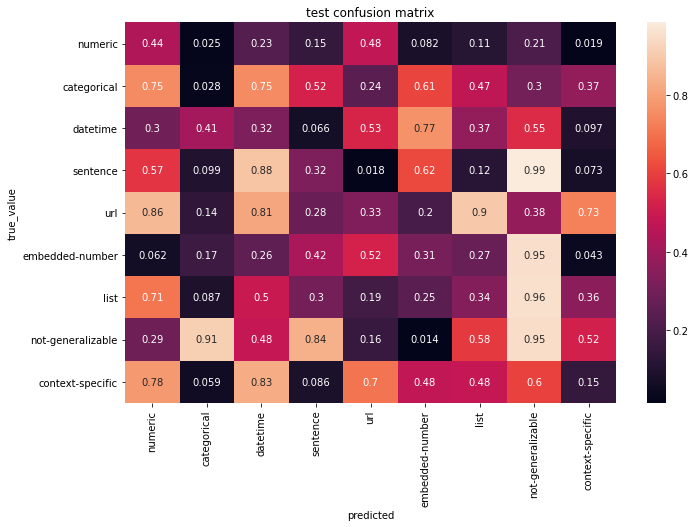

In [11]:
con_matrix = np.random.rand(9,9)
title = "test confusion matrix"
img_folder = "./img"

def save_con_matrix(con_matrix, title, full_path, show=False):
    plt.figure(figsize = (11,7))
    df_cm = pd.DataFrame(con_matrix, index = dict_label_list, columns = dict_label_list)
    sn.heatmap(con_matrix, annot=True, xticklabels=dict_label_list, yticklabels=dict_label_list, ) # font size

    plt.title(title) # title with fontsize 20
    plt.xlabel('predicted') # x-axis label with fontsize 15
    plt.ylabel('true_value') # y-axis label with fontsize 15

    plt.savefig(full_path)

save_con_matrix(con_matrix, title, img_folder + "/test_matrix.png")

In [12]:
feed_his_folder = "./feed"

test_feed = np.random.rand(9,9)

def save_feed(feed, full_path):
    file = open(full_path, 'wb')
    pickle.dump(feed, file)
    
def load_feed(full_path):
    file = open(full_path, 'rb')
    return pickle.load(file)

save_feed(test_feed, feed_his_folder+"/test.pkl")
re = load_feed(feed_his_folder+"/test.pkl")

assert np.all(test_feed == re)

In [13]:
his_folder = "./his"
img_folder = "./img"
feed_folder = "./feed"

def train_this(n_est, max_dept, query_size, max_feed, per_iteration_acc_report = True, feed_his = None):
    
    # getting data
    X_train, y_train, X_sim, y_sim, X_test, y_test = get_data()
    
    # get learner
    preset_batch = partial(uncertainty_batch_sampling, n_instances=query_size)
    learner = ActiveLearner(\
    estimator=RandomForestClassifier(n_estimators=n_est, max_depth=max_dept, random_state=100),
        X_training=X_train, y_training=y_train,
        query_strategy=preset_batch
        )
    
    # init tracker lists
    num_queries = [0]
    time_history = [0]
    total_time_history = [0]
    train_acc_history = [learner.score(X_train, y_train)]
    sim_acc_history = [learner.score(X_sim, y_sim)]
    test_acc_history = [learner.score(X_test, y_test)]
    feed_to_learner = []
    
    print(f"learner trained_acc:{train_acc_history}, sim_acc:{sim_acc_history}, test_acc:{test_acc_history}")
    
    # AL cycle
    t_start = time.time()
    
    while len(feed_to_learner) * query_size < max_feed :
        current_count = len(feed_to_learner) * query_size
        print(f"\n*********** QUERY {current_count} *********** remain:{len(X_sim)}")
        t0 = time.time()
        
        #AL selection
        query_idx = []
        
        if feed_his:
            query_idx = feed_his[0]
            feed_his = feed_his[1:]
        else:
            query_idx, _ = learner.query(np.array(X_sim))
            if current_count + len(query_idx) > max_feed:
                query_idx = query_idx[:current_count + len(query_idx) - max_feed]
                #query_inst = query_inst[:current_count + len(query_idx) - max_feed] 
            
        print(f"Nodes returned for query in query {current_count}: {query_idx}")

        #updating learner
        learner.teach(X = X_sim.iloc[query_idx], y = y_sim.iloc[query_idx])
        feed_to_learner.append(list(query_idx))
        
        X_sim = X_sim.drop(X_sim.index[query_idx])
        y_sim = y_sim.drop(y_sim.index[query_idx])

        #df version
        # delete queries that have been looped back into the model
        #X_simulation_df = X_simulation_df.drop(X_simulation_df.index[query_idx])
        #y_simulation_df = y_simulation_df.drop(y_simulation_df.index[query_idx])

        #np version
        # learner.teach(X = pd.Series(X_simulation_np[idx]), y = y_simulation_np[idx])
        # X_simulation_np = np.delete(X_simulation_np, query_index, axis=0)
        # y_simulation_np = np.delete(y_simulation_np, query_index)
        
        # recording history
        t1 = time.time()
        time_history.append(t1 - t0)
        total_time_history.append(t1 - t_start)
        num_queries.append(len(feed_to_learner)* query_size)

        # Calculate and report our model's accuracy.
        if per_iteration_acc_report:
            test_acc = learner.score(X_test, y_test)
            sim_acc = learner.score(X_sim, y_sim)
            #train_acc = learner.score(X_train, y_train)
                
            test_acc_history.append(  test_acc  )
            sim_acc_history.append(   sim_acc   )
            #train_acc_history.append( train_acc )
            print(f"\n[INTERMEDIATE] test_acc:{test_acc}, sim_acc:{sim_acc}")
            
        print(f"\n[INTERMEDIATE] Time taken for query {current_count}: {time_history[-1]}")
        print(f"\n[INTERMEDIATE] Total time taken {current_count}: {total_time_history[-1]}")

    # saving data into csv
    print("saving data")
    
    al_sampling = "Uncertainty_Batch_Sampling"
    file_name = f"{al_sampling}_ne{n_est}_dept{max_dept}_query{query_size}"
    
    data = {"num_queries": num_queries, "time": time_history, "total_time":total_time_history,\
            #"train_accuracy":train_acc_history, \
            "simulation_accuracy":sim_acc_history,\
            "test_accuracy":test_acc_history}
    save_his(data, f"{his_folder}/{file_name}.csv")
    
    # saving confusion matrix
    y_pred = learner.predict(X_test)
    con_matrix = confusion_matrix(y_test, y_pred)
    title = f"AL using decision tree classifier (n_est = {n_est}, max_dept = {max_dept}) with {al_sampling} (query_size = {query_size})"
    save_con_matrix(con_matrix, title, f"{img_folder}/{file_name}.png")
    
    # saving feed into pickle
    save_feed(feed_to_learner, f"{feed_folder}/{file_name}.pkl")
        
    print("completed")
    
#train_this(n_est=400, max_dept=100, query_size=10)

In [ ]:
#for qs in [10]:
#    train_this(n_est=400, max_dept=100, query_size=qs, max_feed = 1000)

feed_his_folder = "./feed"
         
for qs in [10, 100, 1000]:
    feed_his =None
    try:
        file_name = f"Uncertainty_Batch_Sampling_ne400_dept100_query{qs}"
        feed_his = load_feed(f"{feed_his_folder}/{file_name}.pkl")
    except:
        print(f"feed history for qs {qs} not found, starting fresh")
    train_this(n_est=400, max_dept=100, query_size=qs, max_feed = 6349, feed_his=feed_his)

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)


learner trained_acc:[1.0], sim_acc:[0.8905339423531264], test_acc:[0.8841309823677582]

*********** QUERY 0 *********** remain:6349
Nodes returned for query in query 0: [3477, 3924, 1288, 4036, 5130, 894, 6165, 181, 4038, 3314]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8836272040302267, sim_acc:0.8902035021296735

[INTERMEDIATE] Time taken for query 0: 5.832738161087036

[INTERMEDIATE] Total time taken 0: 5.832754135131836

*********** QUERY 10 *********** remain:6339
Nodes returned for query in query 10: [5314, 5089, 5730, 2777, 2286, 3162, 395, 5847, 3953, 3993]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8856423173803526, sim_acc:0.8928740717332913

[INTERMEDIATE] Time taken for query 10: 3.1248326301574707

[INTERMEDIATE] Total time taken 10: 12.91979718208313

*********** QUERY 20 *********** remain:6329
Nodes returned for query in query 20: [3854, 1516, 3862, 1025, 2642, 6069, 3639, 4689, 4224, 3283]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8846347607052897, sim_acc:0.8920715303054281

[INTERMEDIATE] Time taken for query 20: 1.812061071395874

[INTERMEDIATE] Total time taken 20: 15.629080295562744

*********** QUERY 30 *********** remain:6319
Nodes returned for query in query 30: [6041, 6020, 5820, 4830, 3454, 3739, 3314, 2398, 2647, 3934]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8836272040302267, sim_acc:0.8926929782849897

[INTERMEDIATE] Time taken for query 30: 7.386696100234985

[INTERMEDIATE] Total time taken 30: 26.93230438232422

*********** QUERY 40 *********** remain:6309
Nodes returned for query in query 40: [4261, 5351, 50, 3707, 3622, 177, 5500, 5213, 5365, 4364]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8846347607052897, sim_acc:0.892998888712494

[INTERMEDIATE] Time taken for query 40: 1.961498498916626

[INTERMEDIATE] Total time taken 40: 31.274315118789673

*********** QUERY 50 *********** remain:6299
Nodes returned for query in query 50: [2972, 1732, 6294, 6224, 2173, 2439, 148, 753, 2144, 4262]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8866498740554156, sim_acc:0.8931467641914453

[INTERMEDIATE] Time taken for query 50: 9.0837562084198

[INTERMEDIATE] Total time taken 50: 41.30360794067383

*********** QUERY 60 *********** remain:6289
Nodes returned for query in query 60: [2534, 3520, 859, 6284, 404, 6123, 238, 4018, 1936, 1884]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8821158690176323, sim_acc:0.89265806657111

[INTERMEDIATE] Time taken for query 60: 1.894127368927002

[INTERMEDIATE] Total time taken 60: 49.750778913497925

*********** QUERY 70 *********** remain:6279
Nodes returned for query in query 70: [2332, 3287, 1446, 4661, 767, 3765, 3931, 1217, 5712, 1427]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8881612090680101, sim_acc:0.8936034455256022

[INTERMEDIATE] Time taken for query 70: 5.396891117095947

[INTERMEDIATE] Total time taken 70: 56.05661225318909

*********** QUERY 80 *********** remain:6269
Nodes returned for query in query 80: [125, 2765, 5044, 4371, 2292, 2826, 1543, 3773, 3533, 2952]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8861460957178842, sim_acc:0.8966288544495926

[INTERMEDIATE] Time taken for query 80: 5.679961204528809

[INTERMEDIATE] Total time taken 80: 64.95712375640869

*********** QUERY 90 *********** remain:6259
Nodes returned for query in query 90: [1223, 4468, 14, 2800, 2338, 3981, 4508, 5483, 5329, 3423]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8937027707808565, sim_acc:0.8967834853576572

[INTERMEDIATE] Time taken for query 90: 1.8825411796569824

[INTERMEDIATE] Total time taken 90: 67.75677871704102

*********** QUERY 100 *********** remain:6249
Nodes returned for query in query 100: [1693, 2688, 5589, 1737, 4912, 2918, 5758, 674, 4786, 5246]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.890176322418136, sim_acc:0.8930918416412886

[INTERMEDIATE] Time taken for query 100: 7.193997383117676

[INTERMEDIATE] Total time taken 100: 79.07138848304749

*********** QUERY 110 *********** remain:6239
Nodes returned for query in query 110: [1971, 4439, 6122, 5885, 569, 4467, 3531, 740, 3234, 347]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.891183879093199, sim_acc:0.8983785519344999

[INTERMEDIATE] Time taken for query 110: 2.0433549880981445

[INTERMEDIATE] Total time taken 110: 83.83057761192322

*********** QUERY 120 *********** remain:6229
Nodes returned for query in query 120: [3587, 735, 1454, 6188, 5415, 5871, 5005, 1312, 1436, 426]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8876574307304785, sim_acc:0.8946776009004663

[INTERMEDIATE] Time taken for query 120: 4.120202302932739

[INTERMEDIATE] Total time taken 120: 88.90243101119995

*********** QUERY 130 *********** remain:6219
Nodes returned for query in query 130: [3498, 689, 552, 4550, 1176, 5136, 272, 4392, 2939, 6060]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8931989924433249, sim_acc:0.8970848767917539

[INTERMEDIATE] Time taken for query 130: 6.125751972198486

[INTERMEDIATE] Total time taken 130: 101.15012168884277

*********** QUERY 140 *********** remain:6209
Nodes returned for query in query 140: [1149, 3722, 1968, 4782, 2563, 127, 5962, 2429, 5297, 5832]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.891183879093199, sim_acc:0.8975641232456848

[INTERMEDIATE] Time taken for query 140: 1.9478387832641602

[INTERMEDIATE] Total time taken 140: 104.07108402252197

*********** QUERY 150 *********** remain:6199
Nodes returned for query in query 150: [2953, 5998, 5362, 3180, 2867, 4795, 4832, 2338, 3727, 5750]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.891183879093199, sim_acc:0.8985296493779286

[INTERMEDIATE] Time taken for query 150: 6.572516918182373

[INTERMEDIATE] Total time taken 150: 113.62861013412476

*********** QUERY 160 *********** remain:6189
Nodes returned for query in query 160: [3297, 4540, 5154, 1461, 547, 5218, 5840, 5308, 3024, 882]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8942065491183879, sim_acc:0.8994983006959055

[INTERMEDIATE] Time taken for query 160: 1.9402492046356201

[INTERMEDIATE] Total time taken 160: 119.1602132320404

*********** QUERY 170 *********** remain:6179
Nodes returned for query in query 170: [4258, 876, 5123, 2482, 6007, 2018, 5774, 1528, 3183, 2969]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)


In [ ]:
path = "./his"
files = os.listdir(path)

def get_results():
    for f in files:
        if f.endswith(".csv") and not f.startswith("test"):
            with open(f"{path}/{f}", mode='r') as infile:
                reader = csv.reader(infile)
                temp = zip(*reader)

                results = {"filename": f}
                for i in temp:
                    results[i[0]] = i[1:]
                yield results

plt.figure(figsize=(10,8))
for r in get_results():
    
    print(r.keys())
    plt.plot(r["num_queries"], r["test_accuracy"], label = r["filename"])
    
plt.title("accuracy of 1587 data training and additional 1000 data simluation")
plt.xlabel("# data fed by AL")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 100, 10))
plt.yticks(np.arange(0, 80, 10))
plt.legend()
plt.show()